## Set up the environment

In [1]:
import pandas as pd
import numpy as np
import os
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm
import multiprocessing
from sklearn.neural_network import MLPRegressor

cwd = os.getcwd()
print(cwd)

C:\Users\dleszk01


In [2]:
## helper functions

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

## Load the data

In [3]:
df=pd.read_csv(r'C:\Users\dleszk01\prywatne\IMDB Dataset.csv\IMDB Dataset.csv')
df.head()

,review,sentiment
0,An excellent cast who do their best with an aw...,negative
1,A dreary and pointless bit of fluff (bloody fl...,negative
2,If the writer/director is reading this (and I ...,negative
3,This is a classic B type movie that you'd rath...,negative
4,A short review but...<br /><br />Avoid at all ...,negative


## Preprocessing

- Remove non-digit and non-letter parts

- Remove stop words (but keep the word 'from')

- Remove standalone numbers (remove '100' from '100 pieces')

- Any other text cleaning and standard processing

In [4]:
# Check null values
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [5]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27502 entries, 0 to 27501
Data columns (total 2 columns):
review       27502 non-null object
sentiment    27502 non-null object
dtypes: object(2)
memory usage: 429.8+ KB


In [6]:
# Transform reviews to lowercase
df['review_clean'] = df['review'].astype(str).copy()
df['review_clean'] = df['review_clean'].map(lambda x: x.lower())

### Remove non-digit and non-letter parts

In [7]:
df['review_clean'] = df['review_clean'].map(lambda x: re.sub('[^a-zA-Z0-9|\s]+', '', x))

df.head()

,review,sentiment,review_clean
0,An excellent cast who do their best with an aw...,negative,an excellent cast who do their best with an aw...
1,A dreary and pointless bit of fluff (bloody fl...,negative,a dreary and pointless bit of fluff bloody flu...
2,If the writer/director is reading this (and I ...,negative,if the writerdirector is reading this and i im...
3,This is a classic B type movie that you'd rath...,negative,this is a classic b type movie that youd rathe...
4,A short review but...<br /><br />Avoid at all ...,negative,a short review butbr br avoid at all costs a t...


### Remove standalone numbers (remove '100' from '100 pieces')

In [8]:
df['review_clean'] = df['review_clean'].map(lambda x:re.sub(r'\s*\d+\s*', ' ', x))

df.head()

,review,sentiment,review_clean
0,An excellent cast who do their best with an aw...,negative,an excellent cast who do their best with an aw...
1,A dreary and pointless bit of fluff (bloody fl...,negative,a dreary and pointless bit of fluff bloody flu...
2,If the writer/director is reading this (and I ...,negative,if the writerdirector is reading this and i im...
3,This is a classic B type movie that you'd rath...,negative,this is a classic b type movie that youd rathe...
4,A short review but...<br /><br />Avoid at all ...,negative,a short review butbr br avoid at all costs a t...


### Remove stop words (but keep the word 'from')

In [9]:
# load raw stopwords
stop_words = stopwords.words('english')

# Remove 'from' from stopwords
stop_words.remove('from')

# Make sure that stopwords do not contain 'from' word
print('from' in stop_words)

df['review_clean'] = df['review_clean'].map(lambda x:' '.join([word for word in x.split() if word not in (stop_words)]))

df.head()

False


,review,sentiment,review_clean
0,An excellent cast who do their best with an aw...,negative,excellent cast best awful script inept directi...
1,A dreary and pointless bit of fluff (bloody fl...,negative,dreary pointless bit fluff bloody fluff fluff ...
2,If the writer/director is reading this (and I ...,negative,writerdirector reading imagine since work must...
3,This is a classic B type movie that you'd rath...,negative,classic b type movie youd rather waste time se...
4,A short review but...<br /><br />Avoid at all ...,negative,short review butbr br avoid costs thorough was...


### EDA

Generating a WordCloud of positive reviews...
Generating a WordCloud of negative reviews...


<Figure size 432x288 with 0 Axes>

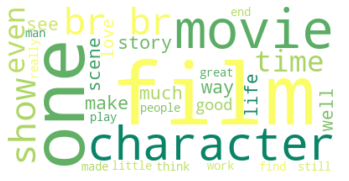

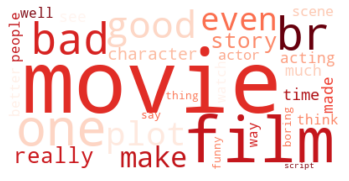

In [10]:
# Generate wordclouds of positive and negative reviews for exploratory purposes and identification of potential stopwords

color_dict = {'positive': 'summer', 'negative':'Reds'}

plt.figure()

for sent in ['positive', 'negative']:
    
    print(f'Generating a WordCloud of {sent} reviews...')
    
    # Join the different processed titles together.
    long_string = ','.join(list(df.loc[df['sentiment']==sent]['review_clean'].values))

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=30, colormap = color_dict[sent])

    # Generate a WordCloud 
    wordcloud.generate(long_string)

    # Visualize the word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

# br is a commonly appearing word which is rubbish information for the algorithm. Let's remove this word from reviews
df['review_clean'] = df['review_clean'].map(lambda x: re.sub('br', '', x))


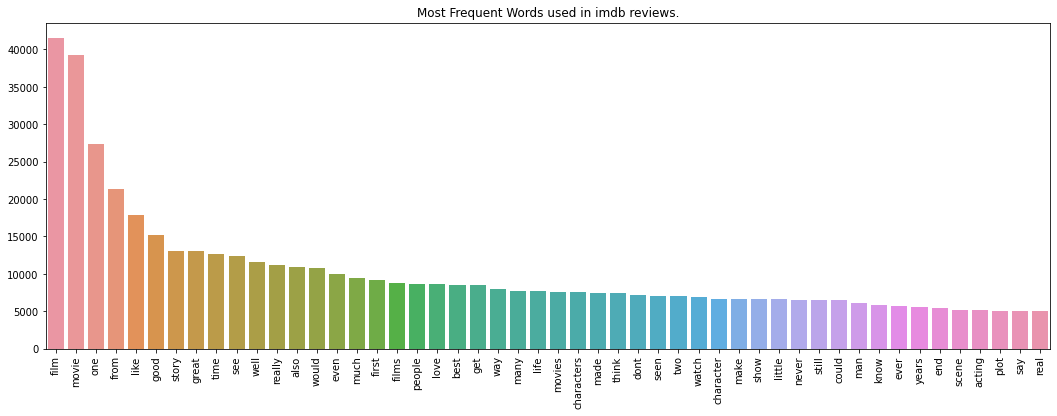

In [11]:
# Explore most common words

aggregate_counter = Counter()
for row_index,row in pd.DataFrame(df['review_clean']).iterrows():
    c = Counter(row['review_clean'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in imdb reviews.')

### Any other text cleaning and standard processing

In [10]:
# Remove empty string reviews
df = df.loc[df['review_clean']!='', :].reset_index(drop=True)

# Replace double spaces with single spaces
df['review_clean'] = df['review_clean'].map(lambda x:re.sub(' {2,}', ' ', x))

# Apply Lemmatization
df['review_tokens'] = df['review_clean'].map(lambda x:x.split())
lemmatizer = WordNetLemmatizer() 
df['review_tokens'] = df['review_tokens'].apply(lambda lst:[lemmatizer.lemmatize(word) for word in lst])
df['review_lemmatized'] = df['review_tokens'].apply(lambda x:' '.join(x))

df.head()

,review,sentiment,review_clean,review_tokens,review_lemmatized
0,An excellent cast who do their best with an aw...,negative,excellent cast best awful script inept directi...,"[excellent, cast, best, awful, script, inept, ...",excellent cast best awful script inept directi...
1,A dreary and pointless bit of fluff (bloody fl...,negative,dreary pointless bit fluff bloody fluff fluff ...,"[dreary, pointless, bit, fluff, bloody, fluff,...",dreary pointless bit fluff bloody fluff fluff ...
2,If the writer/director is reading this (and I ...,negative,writerdirector reading imagine since work must...,"[writerdirector, reading, imagine, since, work...",writerdirector reading imagine since work must...
3,This is a classic B type movie that you'd rath...,negative,classic b type movie youd rather waste time se...,"[classic, b, type, movie, youd, rather, waste,...",classic b type movie youd rather waste time se...
4,A short review but...<br /><br />Avoid at all ...,negative,short review butbr br avoid costs thorough was...,"[short, review, butbr, br, avoid, cost, thorou...",short review butbr br avoid cost thorough wast...


### Explore topics mentioned in the reviews

In [13]:
# Prepare the data for topic modelling
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df['review_lemmatized'])

# Tweak the two parameters below
number_topics = 20
number_words = 15

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
horror one film like from movie scene gore good well monster get time house first

Topic #1:
one from murder best harry ray episode wife columbo kill guy hitchcock train get andrew

Topic #2:
one film from like scene life time movie man thing see love also woman work

Topic #3:
movie film love story scene one from great character good time like life also well

Topic #4:
movie film one like time see really good great think dont watch seen people would

Topic #5:
film year time first one movie disney batman best would music from also like musical

Topic #6:
movie good bad like one action great make effect story guy plot well really from

Topic #7:
game bond play from musical film sinatra one star number james get never also best

Topic #8:
from film one life people like character man movie story world make way get even

Topic #9:
from comedy play get one film two man holmes character arthur good best year role

Topic #10:
film movie good one character gre

## Build a classifier

- Target variable is 'sentiment', build a classifier and assess its performance

### 1) First classifier to be tested is Random Forest

In [14]:
# Transform target variable to dummy variable
df['sentiment'] = [1 if x == 'positive' else 0 for x in df['sentiment']]

In [15]:
# Prepare text corpus for training
corpus=[]

for rev in df['review_lemmatized']:
    corpus.append(rev)
    

In [16]:
# Transform text data into a numeric format (TF IDF matrix)
vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8)
processed_features = vectorizer.fit_transform(corpus).toarray()

In [17]:
# Split data onto train and test sets
labels = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [18]:
# Train and cross validate the estimator

clf = RandomForestClassifier(n_estimators=64, random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='f1')

print(scores)

rf_score = scores.mean()

print(f'Average F1 Score of Random Forest classifier equals: {np.round(rf_score,2)}')

[0.97561453 0.97466001 0.97280376 0.97433386]
Average F1 Score of Random Forest classifier equals: 0.97


### 2) Second classifier to be tested is XGBoost

In [20]:
# Train and cross validate the estimator

from sklearn.model_selection import cross_val_score

clf = xgb.XGBClassifier(objective="binary:logistic", random_state=0)
scores = cross_val_score(clf, X_train, y_train, cv=4, scoring='f1')

print(scores)

xgb_score = scores.mean()

print(f'Average F1 Score of XGBoost classifier equals: {np.round(xgb_score,2)}')

[0.97873182 0.97961203 0.97844998 0.97813829]
Average F1 Score of XGBoost classifier equals: 0.98


##### Since we pay attention to the accuracy of predictions of both, positive and negative labels, F1 Score is selected as a metric decisive of which model should be chosen. This being said, XGBoost slightly outperformed Random Forest classifier in analyzed use-case with cross-validated F1 Score of 0.98.

## Anomaly detection on "review" column

In [22]:
df.head()

,review,sentiment,review_clean,review_tokens,review_lemmatized
0,An excellent cast who do their best with an aw...,0,excellent cast best awful script inept directi...,"[excellent, cast, best, awful, script, inept, ...",excellent cast best awful script inept directi...
1,A dreary and pointless bit of fluff (bloody fl...,0,dreary pointless bit fluff bloody fluff fluff ...,"[dreary, pointless, bit, fluff, bloody, fluff,...",dreary pointless bit fluff bloody fluff fluff ...
2,If the writer/director is reading this (and I ...,0,writerdirector reading imagine since work must...,"[writerdirector, reading, imagine, since, work...",writerdirector reading imagine since work must...
3,This is a classic B type movie that you'd rath...,0,classic b type movie youd rather waste time se...,"[classic, b, type, movie, youd, rather, waste,...",classic b type movie youd rather waste time se...
4,A short review but...<br /><br />Avoid at all ...,0,short review but avoid costs thorough waste mi...,"[short, review, but, avoid, cost, thorough, wa...",short review but avoid cost thorough waste min...


In [23]:
# For anomaly detection of review content we will use already preprocessed in previous task data ("review_lemmatized" column)

In [11]:
class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['review_clean']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm('review_clean')]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['review_clean']).split())
                                     for index, row in df_x.iterrows()]))

In [ ]:
# Transform text corpus into document vectors
doc2vec_tr = Doc2VecTransformer(vector_size=100)
doc2vec_tr.fit(pd.DataFrame(df['review_clean']))
doc2vec_vectors = doc2vec_tr.transform(pd.DataFrame(df['review_clean']))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]
Exception in thread Thread-54:
Traceback (most recent call last):
  File "C:\Users\dleszk01\AppData\Local\Continuum\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\dleszk01\AppData\Local\Continuum\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\dleszk01\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\base_any2vec.py", line 250, in _job_producer
    data_length = self._raw_word_count([data])
  File "C:\Users\dleszk01\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\doc2vec.py", line 617, in _raw_word_count
    return sum(len(sentence.words) for sentence in job)
  File "C:\Users\dleszk01\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\doc2vec.py", line 617, in <genexpr>
    return sum(len(sentence.words) for sentenc

In [ ]:
print(doc2vec_vectors)

In [ ]:
#Train the MLPRegressor and make predictions
auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 600,
                                                 150, 
                                                 600,
                                               ))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

In [ ]:
print(predicted_vectors)

In [ ]:
# Print accuracy score of trained deep regressor
auto_encoder.score(predicted_vectors, doc2vec_vectors)

In [ ]:
# Plot learning curve of trained deep regressor
pd.DataFrame(auto_encoder.loss_curve_).plot()

In [ ]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(pd.DataFrame(df['review_clean']))
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Review Index: ', pd.DataFrame(df['review_clean']).iloc[index, 0])  
        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [ ]:
# Validate the results
print('Top 5 unique reviews')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

In [ ]:
# Check the intersection between most unique move reviews and the most common words extracted from all of the reviews.
# Empty/ small set is an expected result, as it means that most unique (i.e. outlier) reviews do not conain frequent words

most_unique_review_index, cosine_sim_val = sorted_cosine_similarities[0]
most_unique_review_plot = pd.DataFrame(df['review_clean']).iloc[most_unique_review_index, 1]
most_unique_review_words_counter = Counter(preprocess_string(most_unique_review_plot))
intersected_common_word_counter = common_words & most_unique_review_words_counter
intersected_common_words = [word[0] for word in intersected_common_word_counter.items()]
intersected_common_word_counts = [word[1] for word in intersected_common_word_counter.items()]
intersected_common_word_counter